In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import joblib
from tqdm import tqdm

In [2]:
CHAR_SHEET_TRAIN = ['char01(B)', 'char02(D)', 'char03(G)', 'char04(L)', 'char05(O)', 'char06(Q)',
                    'char07(S)', 'char08(V)', 'char09(Z)', 'char10(4)', 'char11(7)', 'char12(9)']
CHAR_SHEET_TEST = ['char' + str(i) for i in range(13, 23)]

In [3]:
def read_single_excel(root, prefix, file_type, sheetName):
    path = os.path.join(root, prefix, prefix + file_type + '.xlsx')
    data = pd.read_excel(path, sheet_name=sheetName, header=None)
    print(f'file path: {path}, \t sheet name: {sheetName}, \t shape: {data.shape}')
    return data
def data_exists(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return os.path.exists(path)
def load_data(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.load(path)
def save_data(root,variable_name,variable):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.dump(variable, path)

In [4]:
# 读取数据
root = './'
train_data, test_data, test_event, train_event = [], [], [], []
if data_exists(root, 'train_data'):
    train_data=load_data(root, 'train_data')
    test_data=load_data(root, 'test_data')
    test_event=load_data(root, 'test_event')
    train_event=load_data(root, 'train_event')
else:
    for i in range(1, 6):
        prefix = 'S' + str(i)
        train_data_i, test_data_i, test_event_i, train_event_i = [], [], [], []
        for sheet_name in CHAR_SHEET_TRAIN:
            train_data_i.append(read_single_excel(root, prefix, '_train_data', sheet_name))
            train_event_i.append(read_single_excel(root, prefix, '_train_event', sheet_name))
        for sheet_name in CHAR_SHEET_TEST:
            if i == 2 and sheet_name == 'char22': # 跳过 S2 数据缺失问题
                test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
                test_event_i.append(None)
                continue
            if i == 3 and sheet_name == 'char22': # 跳过 S3 数据缺失问题
                test_data_i.append(None)
                test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
                continue
            test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
            test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
        train_data.append(train_data_i)
        test_data.append(test_data_i)
        test_event.append(test_event_i)
        train_event.append(train_event_i)
    save_data(root, 'train_data', train_data)
    save_data(root, 'test_data', test_data)
    save_data(root, 'test_event', test_event)
    save_data(root, 'train_event', train_event)
print(f'{len(train_data)}, \t {len(train_event)}, \t {len(test_data)}, \t {len(test_event)}')
print(f'{len(train_data[0])}, \t {len(train_event[0])}, \t {len(test_data[0])}, \t {len(test_event[0])}')
print(type(train_data[0][0]))

5, 	 5, 	 5, 	 5
12, 	 12, 	 10, 	 10
<class 'pandas.core.frame.DataFrame'>


In [5]:
train_data[0][0].iloc[:3000,0]

0       10849.580815
1       10849.893740
2       10848.016193
3       10845.781019
4       10846.719792
            ...     
2995    10960.132537
2996    10962.010083
2997    10966.793356
2998    10967.016874
2999    10966.793356
Name: 0, Length: 3000, dtype: float64

In [53]:
train_data[0][0].shape

(3125, 20)

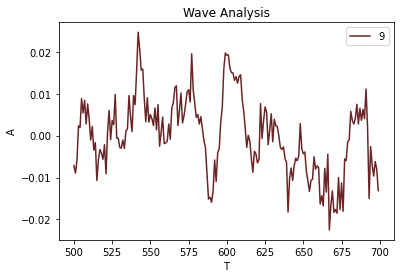

In [6]:
# 画图
time_from_to = [500,int(500+800/4)]
# 4ms一次采样，放缩fuzzy倍
fuzzy = 1
# 观察哪些通道
channels = [8]
# channels = list(range(20))|

np.random.seed(17)
colors = np.random.rand(20,3,)
plt.title('Wave Analysis')
x = list(range(time_from_to[0],time_from_to[1], fuzzy))
y = train_data[0][0].iloc[time_from_to[0]:time_from_to[1],:20]
y = y.loc[x]
for i in channels:
    thisy = y.iloc[:,i]
    # thisy /= np.var(thisy)
    thisy /= np.mean(thisy)
    thisy -= np.mean(thisy)
    plt.plot(x, thisy, color=colors[i], label=str(i+1))
plt.legend() # 显示图例

plt.xlabel('T')
plt.ylabel('A')
plt.show()

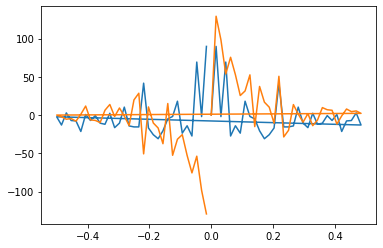

In [7]:
n = 64
sp=np.fft.fft(train_data[3][10].iloc[:,0],n=n)
sp[np.abs(sp)>3000]=0
freq = np.fft.fftfreq(n)
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()
# print(sp,freq)

In [54]:
# 特征工程

n = 64

'''
A	101	B	102	C	103	D	104	E	105	F	106
G	107	H	108	I	109	J	110	K	111	L	112
M	113	N	114	O	115	P	116	Q	117	R	118
S	119	T	120	U	121	V	122	W	123	X	124
Y	125	Z	126	1	127	2	128	3	129	4	130
5	131	6	132	7	133	8	134	9	135	0	136
'''
map_char_id={
    "A":101,"B":102,"C":103,"D":104,"E":105,"F":106,
    "G":107,"H":108,"I":109,"J":110,"K":111,"L":112,
    "M":113,"N":114,"O":115,"P":116,"Q":117,"R":118,
    "S":119,"T":120,"U":121,"V":122,"W":123,"X":124,
    "Y":125,"Z":126,"1":127,"2":128,"3":129,"4":130,
    "5":131,"6":132,"7":133,"8":134,"9":135,"0":136,
}
map_id_char={}
for char,id in map_char_id.items():
    map_id_char[id]=char
exists_xy_char=["","ABCDEF","GHIJKL","MNOPQR","STUVWX","YZ1234","567890","AGMSY5","BHNTZ6","CIOU17","DJPV28","EKQW39","FLRX40"]
for i,v in enumerate(exists_xy_char):
    m = set()
    for c in v:
        m.add(c)
    exists_xy_char[i]=m

def get_data():
    features = []
    tags = []
    for i_person in tqdm(range(5)):
        for i_char_sheet in range(len(CHAR_SHEET_TRAIN)):
            char_id=train_event[i_person][i_char_sheet].iloc[0,0]
            char=map_id_char[char_id]
            begin_time=train_event[i_person][i_char_sheet].iloc[0,1]
            for i_row in range(1,len(train_event[i_person][i_char_sheet]),13):
                data_group = train_event[i_person][i_char_sheet].iloc[i_row:i_row+12]
                # print(data_group,i_row)
                for i in range(12):
                    sp=np.concatenate([
                        np.abs(np.fft.fft(
                            train_data[i_person][i_char_sheet].iloc[
                                int(data_group.iloc[i,1])+20 : int(data_group.iloc[i,1])+100,
                            j],n=n
                        )) for j in range(20)
                    ])
                    sp[np.abs(sp)>5000]=0
                    features.append(sp)
                    tags.append(int(char in exists_xy_char[int(data_group.iloc[i,0])]))
    return np.asarray(features),np.asarray(tags)
features, tags = get_data()


100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


In [55]:
np.asarray(features).shape

(3600, 1280)

In [56]:
np.asarray(features).shape,np.asarray(tags).shape

((3600, 1280), (3600,))

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

def svc_cv(C, degree, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVC(C=C, kernel='poly', random_state=2, degree=degree)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()

def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""

    def svc_crossval(expC, degree):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        degree = int(degree)
        return svc_cv(C=C, degree=degree, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (-2, 2), "degree": (1, 10)},
        random_state=3333,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

optimize_svc(features,tags)

|   iter    |  target   |  degree   |   expC    |
-------------------------------------------------
|  1        |  0.5242   |  7.764    | -1.563    |
|  2        |  0.4941   |  5.375    | -0.000675 |
|  3        |  0.5184   |  6.914    | -1.056    |
|  4        |  0.5219   |  6.515    | -1.521    |
|  5        |  0.5016   |  7.41     | -0.5098   |
|  6        |  0.5211   |  7.171    | -1.984    |
|  7        |  0.5249   |  8.773    | -2.0      |
|  8        |  0.5206   |  9.998    | -1.539    |
|  9        |  0.4867   |  1.0      | -2.0      |
|  10       |  0.4939   |  1.0      |  2.0      |
|  11       |  0.5105   |  10.0     |  2.0      |
|  12       |  0.5113   |  10.0     | -0.04626  |
|  13       |  0.5006   |  4.562    | -2.0      |
|  14       |  0.5059   |  3.828    |  2.0      |
|  15       |  0.5173   |  8.982    | -1.19     |
Final result: {'target': 0.52492, 'params': {'degree': 8.773049122570436, 'expC': -2.0}}


In [58]:
def train(expC, degree):
    x, y = np.asarray(features), np.asarray(tags)
    # C_range = np.logspace(-2, 5, 10)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份
    # gamma_range = np.logspace(-9, 3, 10)
    # param_grid = dict(gamma=gamma_range, C=C_range)
    # cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    # p = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    C = 10 ** expC
    degree = int(degree)
    p=SVC(C=C, kernel='poly', random_state=2, degree=degree)
    p.fit(x, y)
    return p

model = train(degree=8.773049122570436, expC=-2.0)

In [21]:
print(np.array([1,2,3])[np.nonzero([True,False,True])])

[1 3]


In [22]:
# np.nonzero(tags==1)
tags_pred=model.predict(features)

1.0

In [59]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
# 准确率
#precision = np.sum(tags_pred[np.nonzero(tags==1)])/np.sum(tags_pred==1)
precision = accuracy_score(np.asarray(tags), tags_pred)
# 召回率
#recall = np.sum(tags_pred[np.nonzero(tags==1)])/(np.sum(tags_pred[np.nonzero(tags==1)]==1)+np.sum(tags==1))
recall = recall_score(np.asarray(tags), tags_pred)
precision, recall

(0.9094444444444445, 0.45666666666666667)